In [1]:
# Imports
import os
import sys
import numpy as np
from functools import partial
from importlib import reload
from time import sleep, time
from matplotlib import pyplot as plt
%matplotlib nbagg

# SilQ imports
import silq
from silq.analysis import analysis
from silq.parameters import measurement_parameters, general_parameters


# Qcodes imports
import qcodes as qc
from qcodes import Instrument
from qcodes.instrument.parameter import Parameter, ManualParameter, StandardParameter
from qcodes.data import hdf5_format
from qcodes.data.data_set import DataSet
h5fmt = hdf5_format.HDF5Format()

from qcodes.data.manager import DataManager, DataServer
from qcodes.data.data_set import new_data, DataMode
from qcodes.data.data_array import DataArray


# Data handling
qc.data.data_set.DataSet.default_io.base_location = 'E:\EWJN\data'
loc_provider = qc.data.location.FormatLocation(fmt='{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

<IPython.core.display.Javascript object>

In [2]:
qc.show_subprocess_widget()

In [3]:
# General functions
def plot_traces(traces, traces_AWG=None, threshold_voltage=None):
    plt.figure()
    plt.pcolormesh(range(traces.shape[1]), 
                 range(traces.shape[0]+1), traces)
    if traces_AWG is not None:
        trace_AWG = traces_AWG[:1]
        trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
        trace_AWG -= np.min(trace_AWG)
        plt.pcolormesh(range(traces.shape[1]), 
                       np.array([0,1])+traces.shape[0], trace_AWG)
    plt.xlim([0,traces.shape[1]])
    plt.ylim([0,traces.shape[0]+1])
    plt.gca().invert_yaxis()
    plt.colorbar()

    fig, axes = plt.subplots(len(traces), sharex=True)
    for k, trace in enumerate(traces):
        axes[k].plot(trace)
#         axes[k].plot(trace > 0.5)
        if traces_AWG is not None:
            trace_AWG = traces_AWG[k]
            trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
            trace_AWG -= np.min(trace_AWG)
            axes[k].plot(trace_AWG)
        if threshold_voltage is not None:
            axes[k].plot([threshold_voltage]*len(trace), 'r')
        axes[k].locator_params(nbins=2)

def try_close_instruments(instruments=['pulseblaster', 'arbstudio', 'SIM900', 'ATS', 'ATS_controller', 'pulsemaster'], 
                          reload=False):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument_name in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass
        try:
            eval('reload({}_driver)'.format(instrument_name))
        except:
            pass
        
def print_voltages(SIM900):
    for channel, name in SIM900.channels().items():
        print('{}({})'.format(name, SIM900.parameters[name]()))

In [4]:
# Add an extra data manager for trace saving
data_manager = qc.data.manager.get_data_manager()
data_manager_raw = DataManager(server_name='Raw_DataServer')
data_manager_raw.base_location = DataSet.default_io.base_location
qc.data.manager.DataManager.default = data_manager

In [5]:
# Load instruments
import qcodes.instrument_drivers.lecroy.ArbStudio1104 as arbstudio_driver
import qcodes.instrument_drivers.spincore.PulseBlasterESRPRO as pulseblaster_driver
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver
from silq.meta_instruments.pulsemaster import PulseMaster as pulsemaster_driver

try_close_instruments()

dll_path = os.path.join(os.getcwd(),'C:\lecroy_driver\\Library\\ArbStudioSDK.dll')
arbstudio = arbstudio_driver.ArbStudio1104('ArbStudio', dll_path)

pulseblaster = pulseblaster_driver.PulseBlaster('PulseBlaster', api_path='spinapi.py')

SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
for ch_name, ch, max_voltage in [('TG',1,18), ('LB',2,3.8), ('RB',3,3.8), ('TGAC',4,3), 
                                 ('SRC',5,1), ('DS',7,3.2), ('DF',6,3.2)]:
    SIM900.define_slot(channel=ch, name=ch_name, max_voltage=max_voltage)
    SIM900.update()
    exec('{ch_name} = SIM900.parameters["{ch_name}"]'.format(ch_name=ch_name))


ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Basic_AcquisitionController(name='ATS_controller', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

pulsemaster=pulsemaster_driver.PulseMaster(pulseblaster=pulseblaster, 
                                           arbstudio=arbstudio, 
                                           ATS=ATS, 
                                           ATS_controller=ATS_controller, 
                                           server_name='PulseMaster_server')

# Additional parameters
reload(general_parameters)
reload(measurement_parameters)
dummy_param = ManualParameter(name='dummy', initial_value=42)
DF_DS = general_parameters.CombinedParameter(parameters=[DF, DS])
ELR_parameter = measurement_parameters.ELR_Parameter(pulsemaster=pulsemaster)
T1_parameter = measurement_parameters.T1_Parameter(pulsemaster=pulsemaster)
DC_parameter = measurement_parameters.DC_Parameter(pulsemaster=pulsemaster)
ELRLR_parameter = measurement_parameters.ELRLR_Parameter(pulsemaster=pulsemaster)
variable_read_parameter = measurement_parameters.VariableRead_Parameter(pulsemaster=pulsemaster)

# Modify default parameter values
parameters = [ELR_parameter, T1_parameter, ELRLR_parameter, variable_read_parameter]
for parameter in parameters:
    parameter.stages['load']['voltage'] = 2.5
    parameter.stages['empty']['duration'] = 20


station = qc.Station(arbstudio, pulseblaster, ATS, ATS_controller, pulsemaster, SIM900,
                     DF_DS, ELR_parameter, T1_parameter, DC_parameter, ELRLR_parameter, variable_read_parameter)

# Single measurements

In [99]:
# Determine empty, load, read fidelities
ELR_parameter.setup(samples=400)
%time fidelities = ELR_parameter()
pulsemaster.stop()
print('Empty: {:.2f}, Load: {:.2f}, Read: {:.2f}'.format(*fidelities))

Wall time: 15.5 s
Empty: 0.56, Load: 0.96, Read: 0.88


In [106]:
T1_parameter.setup(samples=1000)
T1_parameter(5)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

T1_parameter.setup(samples=200)
T1_parameter(3000)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

pulsemaster.stop()

Wall time: 1min 10s
Up proportion: 0.47
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
Wall time: 10min 6s
Up proportion: 0.00


# DC sweep

### TGAC vs DF_DS

In [18]:
TGAC_vals = list(np.linspace(0.5,1.5, 40))
DF_DS_vals = list(np.linspace(2.61,2.85,50))

In [19]:
DC_parameter.setup()
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(DC_parameter
                          ).run(name='DC_sweep',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-19/#006_DC_sweep_11-49-17'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | SIM900_TGAC_set | TGAC         | (40,)
   Setpoint | DF_DS_set       | DF_DS        | (40, 50)
   Measured | DC_voltage      | DC_voltage   | (40, 50)
started at 2016-09-19 11:49:18


<IPython.core.display.Javascript object>


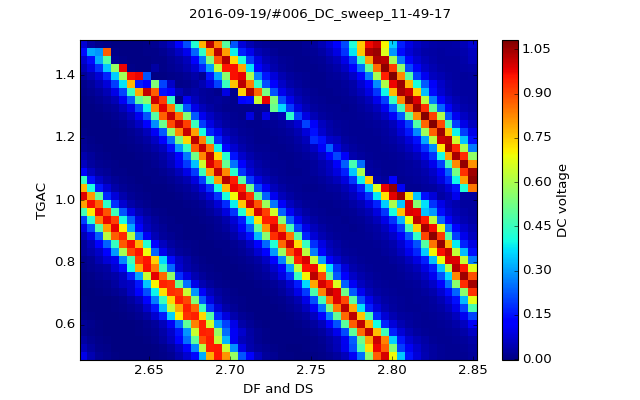

C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [20]:
plot = qc.MatPlot()
plot.add(data.DC_voltage)
# plotQ = qc.QtPlot()
# plotQ.add(data.DC_voltage)

<IPython.core.display.Javascript object>


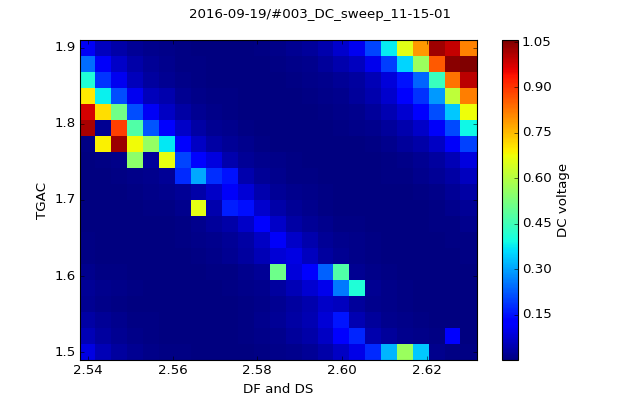

In [13]:
plot = qc.MatPlot()
plot.add(data.DC_voltage)
# plotQ = qc.QtPlot()
# plotQ.add(data.DC_voltage)

# ELRLR sequence

In [35]:
TGAC_vals = list(np.round(np.linspace(1.836,1.843,5),3))
DF_DS_vals = list(np.round(np.linspace(2.565,2.57,5),3))

In [37]:
ELRLR_parameter.setup(samples=150)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(ELRLR_parameter
                          ).run(name='ELRLR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-18/#009_ELRLR_calibration_13-43-39'
   <Type>   | <array_id>      | <array.name>   | <array.shape>
   Setpoint | SIM900_TGAC_set | TGAC           | (5,)
   Setpoint | DF_DS_set       | DF_DS          | (5, 5)
   Measured | fidelity_empty  | fidelity_empty | (5, 5)
   Measured | fidelity_load   | fidelity_load  | (5, 5)
   Measured | fidelity_read   | fidelity_read  | (5, 5)
   Measured | up_proportion   | up_proportion  | (5, 5)
   Measured | dark_counts     | dark_counts    | (5, 5)
   Measured | contrast        | contrast       | (5, 5)
started at 2016-09-18 13:43:40


In [38]:
plotQ = qc.QtPlot()
plotQ.add(data.contrast)

plotQ = qc.QtPlot()
plotQ.add(data.dark_counts)

plotQ = qc.QtPlot()
plotQ.add(data.fidelity_load)

plotQ = qc.QtPlot()
plotQ.add(data.fidelity_empty)

c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtg

In [44]:
DF_DS_vals[2]

2.5680000000000001

In [51]:
TGAC(1.84)
DF_DS(2.568)

In [49]:
TGAC(1.836)
DF_DS(2.57)

In [52]:
ELRLR_parameter.setup(samples=400, print=True)
ELRLR_parameter();

fidelity_empty: 0.990
fidelity_load: 0.891
fidelity_read: 0.689
up_proportion: 0.515
dark_counts: 0.188
contrast: 0.328


# Read level sweep

In [7]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-19/#001_variable_read_10-30-49'
   <Type>   | <array_id>                | <array.name>          | <array.shape>
   Setpoint | variable_read_voltage_set | variable_read_voltage | (100,)
   Measured | index0                    | index0                | (100, 8992)
   Measured | Channel_A_signal          | Channel_A_signal      | (100, 8992)
   Measured | Channel_C_signal          | Channel_C_signal      | (100, 8992)
started at 2016-09-19 10:31:00


In [42]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

In [53]:
# Prepare measurements: Determine threshold voltage
ELR_parameter.setup(samples=300, return_traces=True)
_, _, _, _, _,traces, traces_AWG = ELR_parameter()
pulsemaster.stop()
_, _, threshold_voltage = analysis.find_high_low(traces)
assert threshold_voltage is not None, "Couldn't find accurate threshold"
print('Threshold voltage found at {:.2f} V'.format(threshold_voltage))

Threshold voltage found at 0.44 V


In [54]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1,4,num=20,base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [4832.9302385717519, 3359.8182862837812, 263.66508987303581, 1128.8378916846884, 10.0, 6951.9279617756056, 545.55947811685144, 1623.776739188721, 14.384498882876629, 784.75997035146065, 88.586679041008225, 379.26901907322497, 20.691380811147901, 42.813323987193932, 183.29807108324357, 29.763514416313178, 61.584821106602639, 127.42749857031335, 10000.0, 2335.7214690901214]


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-14/#033_T1_single_sweep_16-33-44'
   <Type>   | <array_id>        | <array.name>      | <array.shape>
   Setpoint | T1_wait_time_set  | T1_wait_time      | (5,)
   Measured | up_proportion     | up_proportion     | (5,)
   Measured | num_traces_loaded | num_traces_loaded | (5,)
started at 2016-09-14 16:33:45


<IPython.core.display.Javascript object>


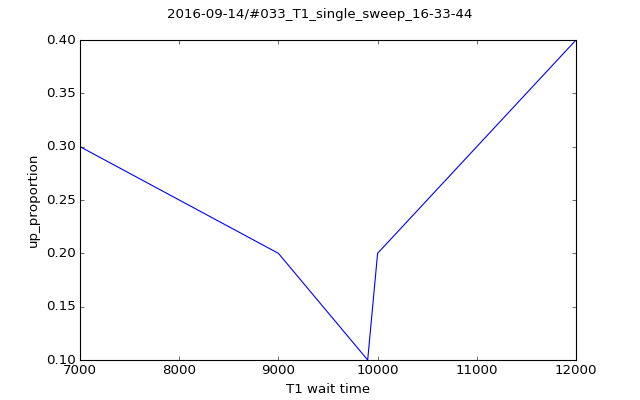

In [38]:
# Single T1 sweep
T1_parameter.setup(threshold_voltage=threshold_voltage, samples=10)

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

In [10]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-16/#011_T1_data_13-04-18'
   <Type>   | <array_id>          | <array.name>      | <array.shape>
   Setpoint | dummy_set           | dummy             | (30,)
   Measured | fidelity_empty      | fidelity_empty    | (30,)
   Measured | fidelity_load       | fidelity_load     | (30,)
   Measured | fidelity_read       | fidelity_read     | (30,)
   Measured | up_proportion_1_3   | up_proportion     | (30,)
   Measured | dark_counts         | dark_counts       | (30,)
   Measured | contrast            | contrast          | (30,)
   Setpoint | T1_wait_time_set    | T1_wait_time      | (30, 20)
   Measured | up_proportion_3_0_0 | up_proportion     | (30, 20)
   Measured | num_traces_loaded   | num_traces_loaded | (30, 20)
started at 2016-09-16 13:04:20
